### Machine Learning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from yellowbrick.cluster import SilhouetteVisualizer, InterclusterDistance, KElbowVisualizer
from sklearn.metrics import silhouette_score, adjusted_rand_score
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
df = pd.read_csv(
    r'C:\Users\Damien\Desktop\Data Scientist\P5\Dataset\olist_clean.csv')

In [3]:
df

,product_id,payment_type,customer_unique_id,Recency,frequence_achat,dist_cust_seller,product_category_name_english,payment_value,review_score,delivery_time,m_quartile,customer_city
0,4244733e06e7ecb4970a6e2683c13e61,1,871766c5855e863f6eccc05f988b23cb,399,1,301.006080,other,72.19,5,7.0,3,1.0
1,4244733e06e7ecb4970a6e2683c13e61,0,0fb8e3eab2d3e79d92bb3fffbb97f188,476,1,943.873300,other,73.86,5,15.0,3,0.0
2,4244733e06e7ecb4970a6e2683c13e61,1,3419052c8c6b45daf79c1e426f9e9bcb,152,1,287.307755,other,83.23,4,17.0,3,4.0
3,4244733e06e7ecb4970a6e2683c13e61,1,e7c828d22c0682c1565252deefbe334d,442,1,608.577657,other,75.07,5,8.0,3,0.0
4,4244733e06e7ecb4970a6e2683c13e61,1,0bb98ba72dcc08e95f9d8cc434e9a2cc,433,1,207.980995,other,72.19,5,14.0,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
94238,3a96bcbf644a5d390107570628568026,1,e839774c9d31569dba47946296e58b33,84,1,74.994369,media,27.20,5,2.0,4,1.0
94239,2b54fb9a4acf707537eb53eb2458c241,1,8c3c961a52bb5a0ffbce1d4e6d25cd67,81,1,623.993701,media,77.50,5,6.0,3,0.0
94240,9c313adb4b38a55b092f53f83f78be9e,1,8d80e477643ec569b24592ce3d9dfc4c,86,1,254.171222,media,84.63,3,4.0,3,1.0
94241,5aa0d6ed4e6c0995d62090cd82cde89a,0,428f4721a509be8c52de6ec2900ba918,55,1,289.354874,media,24.69,5,5.0,4,0.0


## Model1 (RFM avec log + StandardScaler) 

In [4]:
# On passe Payment Value au log
df['Recency_log'] = np.log1p(df['Recency'])
df['Frequency_log'] = np.log1p(df['frequence_achat'])
df['Monetary_log'] = np.log1p(df['payment_value'])

In [5]:
df['Recency_t'] = StandardScaler().fit_transform(df.loc[:, ['Recency_log']])
df['Frequency_t'] = StandardScaler().fit_transform(df.loc[:, ['Frequency_log']])
df['Monetary_t'] = StandardScaler().fit_transform(df.loc[:, ['Monetary_log']])

In [6]:
customers = pd.DataFrame()
customers['Recency'] = df['Recency_t']
customers['Frequence'] = df['Frequency_t']
customers['Monetary'] = df['Monetary_t']
customers.reset_index(inplace=True)

In [7]:
customers = customers.drop(['index'], axis=1)

#### PCA

In [8]:
n_comp = 2
pca = PCA(n_components=n_comp)
features = customers.columns
data_pca = pca.fit_transform(customers)
pcs = pca.components_

In [9]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=True, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks:  # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10, 10))

            # détermination des limites du graphique
            if lims is not None:
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30:
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else:
                xmin, xmax, ymin, ymax = min(pcs[d1, :]), max(
                    pcs[d1, :]), min(pcs[d2, :]), max(pcs[d2, :])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30:
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                           pcs[d1, :], pcs[d2, :],
                           angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0, 0], [x, y]] for x, y in pcs[[d1, d2]].T]
                ax.add_collection(LineCollection(
                    lines, axes=ax, alpha=.1, color='black'))

            # affichage des noms des variables
            if labels is not None:
                for i, (x, y) in enumerate(pcs[[d1, d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax:
                        plt.text(x, y, labels[i], fontsize='14', ha='center',
                                 va='center', rotation=label_rotation, color="blue", alpha=0.5)

            # affichage du cercle
            an = np.linspace(0, 2 * np.pi, 100)  # Add a unit circle for scale
            plt.plot(np.cos(an), np.sin(an))
            plt.axis('equal')

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)

            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(
                d1+1, round(100*pca.explained_variance_ratio_[d1], 1)))
            plt.ylabel('F{} ({}%)'.format(
                d2+1, round(100*pca.explained_variance_ratio_[d2], 1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

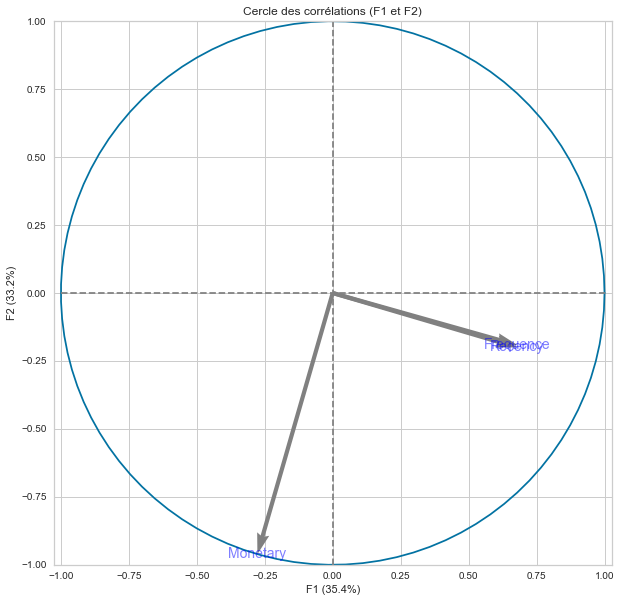

In [10]:
display_circles(pcs, n_comp, pca, [(0, 1)], labels=np.array(features))

In [11]:
# Eboulis des valeurs propres
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.figure(figsize=(8, 8))
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(), c='red', marker='o')
    plt.xlabel('rang de l'axe d'inertie')
    plt.ylabel('pourcentage d'inertie')
    plt.title('Eboulis des valeurs propres')
    plt.show(block=False)

In [12]:
print(pca.explained_variance_ratio_)

[0.35416185 0.33160272]


In [13]:
print(abs(pca.components_))

[[0.67890559 0.67996018 0.2770223 ]
 [0.20008858 0.19167933 0.96084525]]


La dimension de pca.components_ est [n_components, n_features]. La première ligne donne donc les dégré d'importance des features pour PC1

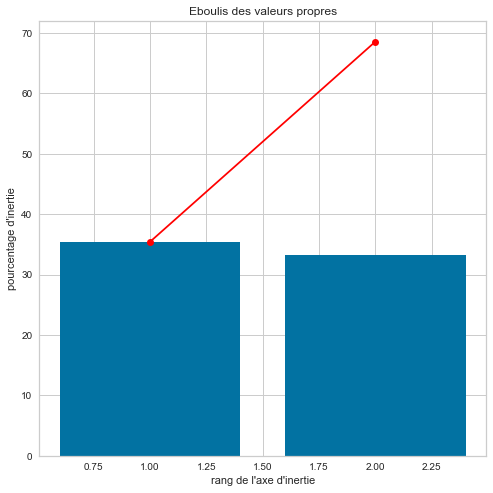

In [14]:
display_scree_plot(pca)

#### Dandogramme

In [15]:
customers_sample = customers.sample(10000)

In [16]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

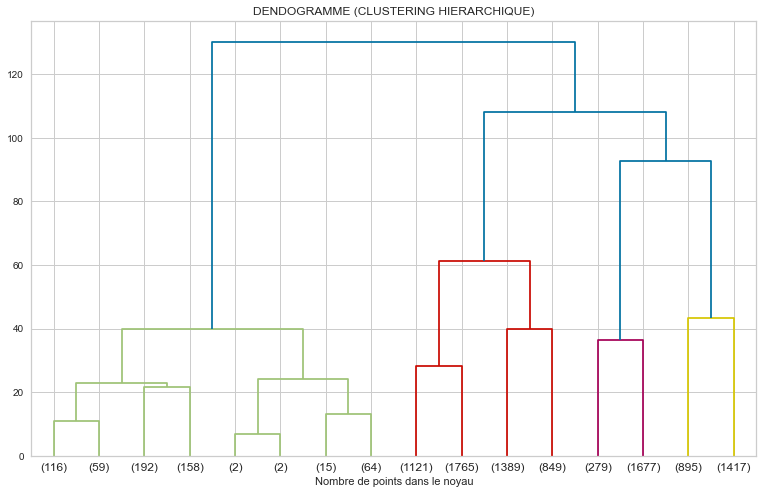

In [17]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(customers_sample)
plt.figure(figsize=(13, 8))
plt.title('DENDOGRAMME (CLUSTERING HIERARCHIQUE)')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel('Nombre de points dans le noyau')
plt.show()

#### KMeans

In [18]:
inertia = []
K_range = range(1, 20)
for k in K_range:
    model = KMeans(n_clusters=k).fit(data_pca)
    inertia.append(model.inertia_)

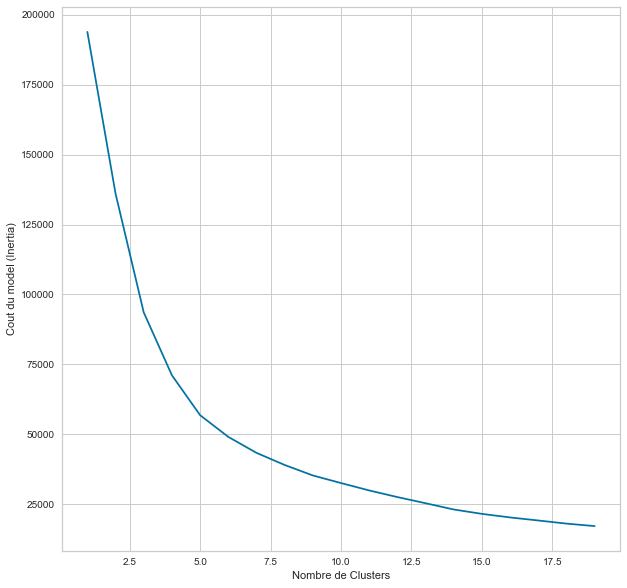

In [19]:
plt.figure(figsize=(10, 10))
plt.plot(K_range, inertia)
plt.xlabel('Nombre de Clusters')
plt.ylabel('Cout du model (Inertia)')
plt.show()

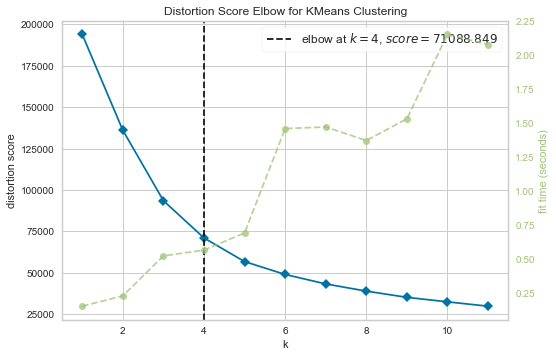

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [20]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 12))

visualizer.fit(data_pca)    # Fit the data to the visualizer
visualizer.show()    # Finalize and render the figure

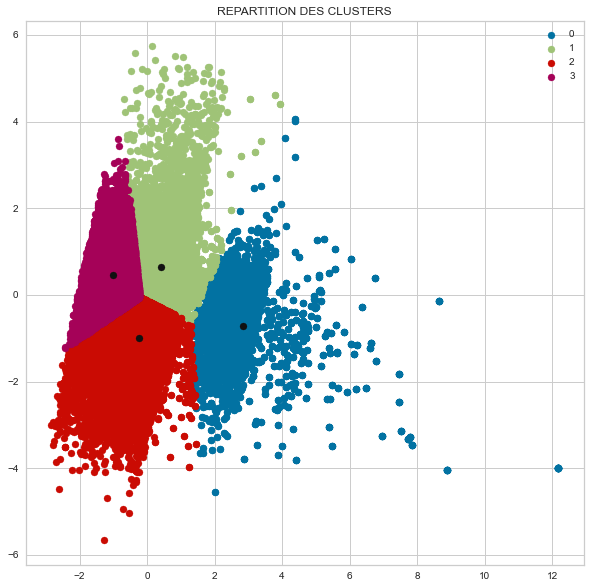

In [21]:
model = KMeans(n_clusters=4)

# Prediction
label = model.fit_predict(data_pca)
centroids = model.cluster_centers_

# Graphical representation
plt.figure(figsize=(10, 10))
plt.scatter(data_pca[label == 0, 0], data_pca[label == 0, 1], label=0)
plt.scatter(data_pca[label == 1, 0], data_pca[label == 1, 1], label=1)
plt.scatter(data_pca[label == 2, 0], data_pca[label == 2, 1], label=2)
plt.scatter(data_pca[label == 3, 0], data_pca[label == 3, 1], label=3)
plt.scatter(centroids[:, 0], centroids[:, 1], color='k')
plt.legend()
plt.title('REPARTITION DES CLUSTERS')
plt.show()

#### Evaluation du modèle

In [22]:
df['model1_cluster'] = label
df_cluster = df.groupby('model1_cluster').agg({
    'Recency': 'mean',
    'frequence_achat': 'mean',
    'payment_value': 'mean'})
df_cluster

,Recency,frequence_achat,payment_value
model1_cluster,,,
0,349.508793,2.279194,135.467615
1,355.640658,1.012718,63.898391
2,321.879617,1.010035,310.492981
3,116.800809,1.000000,106.880470


Text(0.5, 1.0, 'Monetary / Cluster')

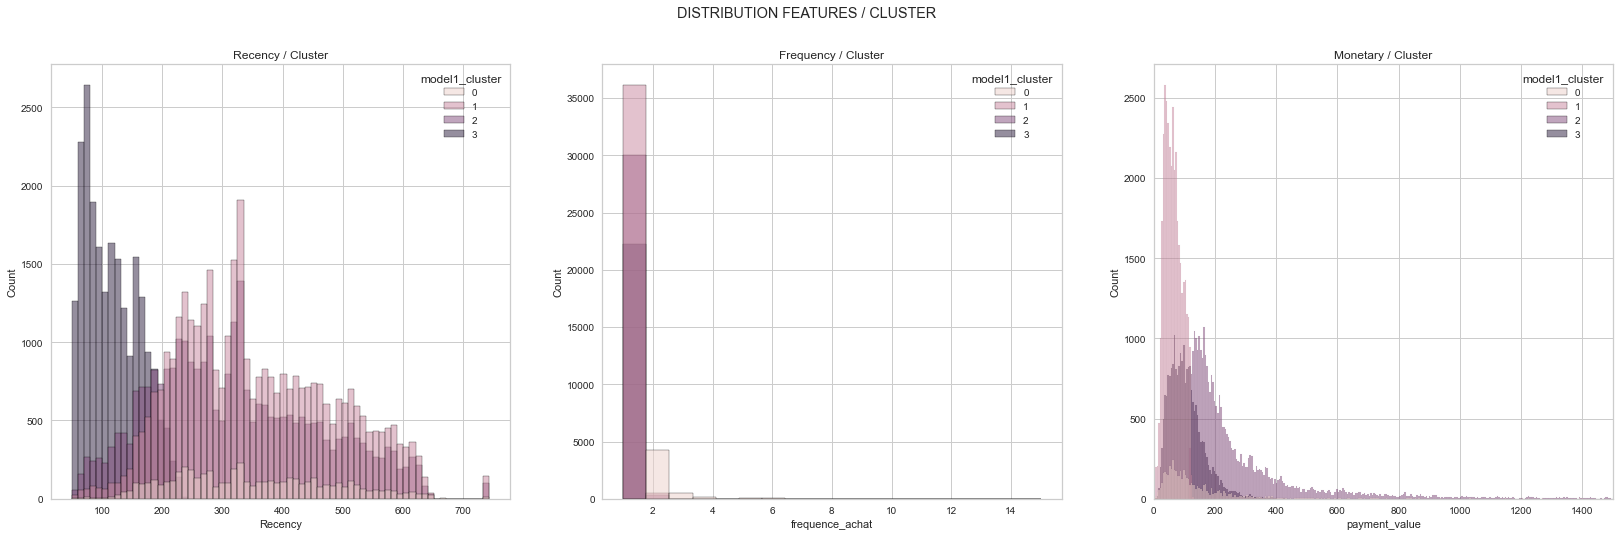

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(28, 8), sharey=False)
fig.suptitle('DISTRIBUTION FEATURES / CLUSTER')

# Recency / Cluster
sns.histplot(ax=axes[0], data=df, x='Recency', hue='model1_cluster')
axes[0].set_title('Recency / Cluster')

# Frequency / Cluster
sns.histplot(ax=axes[1], data=df, x='frequence_achat', hue='model1_cluster')
axes[1].set_title('Frequency / Cluster')

# Monetary / Cluster
sns.histplot(ax=axes[2], data=df, x='payment_value', hue='model1_cluster')
plt.xlim(0, 1500)
axes[2].set_title('Monetary / Cluster')

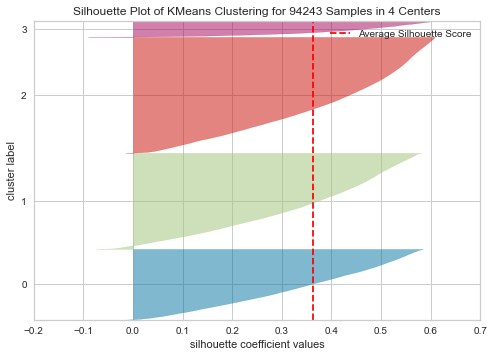

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 94243 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [24]:
model = KMeans(n_clusters=4)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(data_pca)
visualizer.show()

In [25]:
print('Silhouette Score:', silhouette_score(data_pca, label))

Silhouette Score: 0.362499041425582


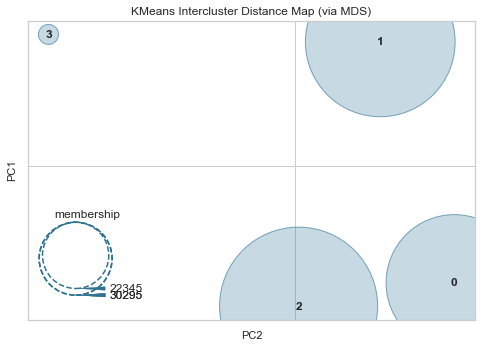

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [26]:
visualizer = InterclusterDistance(model)

visualizer.fit(data_pca)
visualizer.show()

## Model 2 (5 features avec log + StandardScaler)

In [27]:
df['Delivery_log'] = np.log1p(df['delivery_time'])
df['Distance_log'] = np.log1p(df['dist_cust_seller'])

In [28]:
df['Delivery_t'] = StandardScaler().fit_transform(df.loc[:, ['Delivery_log']])
df['Distance_t'] = StandardScaler().fit_transform(df.loc[:, ['Distance_log']])

In [29]:
customers2 = pd.DataFrame()
customers2['Recency'] = df['Recency_t']
customers2['Frequence'] = df['Frequency_t']
customers2['Monetary'] = df['Monetary_t']
customers2['Delivery'] = df['Delivery_t']
customers2['Distance'] = df['Distance_t']
customers2.reset_index(inplace=True)

In [30]:
customers2 = customers2.drop(['index'], axis=1)

#### PCA

In [31]:
n_comp = 2
pca = PCA(n_components=n_comp)
features2 = customers2.columns
data_pca2 = pca.fit_transform(customers2)
pcs = pca.components_

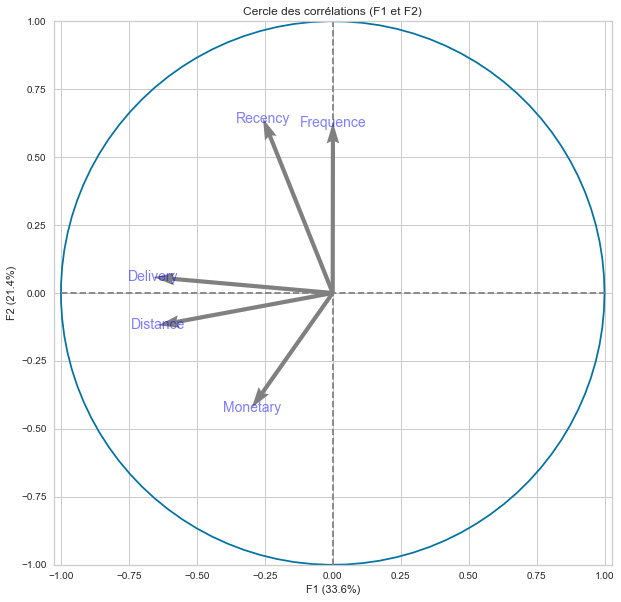

In [32]:
display_circles(pcs, n_comp, pca, [(0, 1)], labels=np.array(features2))

In [33]:
print(pca.explained_variance_ratio_)

[0.3357121  0.21396128]


In [34]:
print(abs(pca.components_))

[[0.25624541 0.00097914 0.29778893 0.65897217 0.64141622]
 [0.64112765 0.62702005 0.422204   0.05822382 0.11897466]]


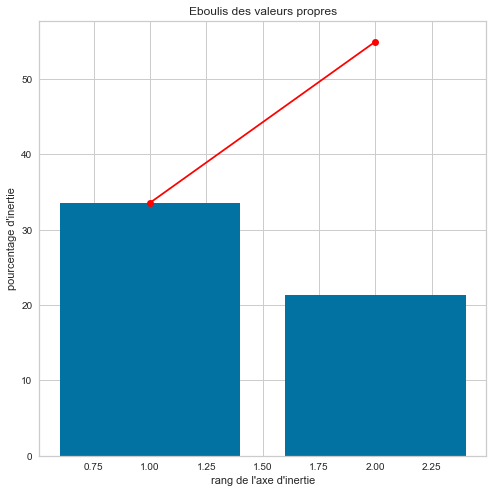

In [35]:
display_scree_plot(pca)

#### Dendogramme

In [36]:
customers2_sample = customers2.sample(10000)

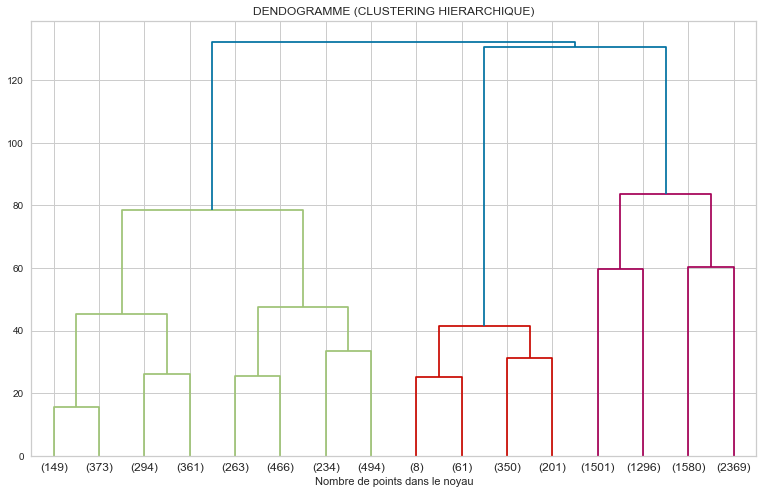

In [37]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(customers2_sample)
plt.figure(figsize=(13, 8))
plt.title('DENDOGRAMME (CLUSTERING HIERARCHIQUE)')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel('Nombre de points dans le noyau')
plt.show()

#### Kmeans

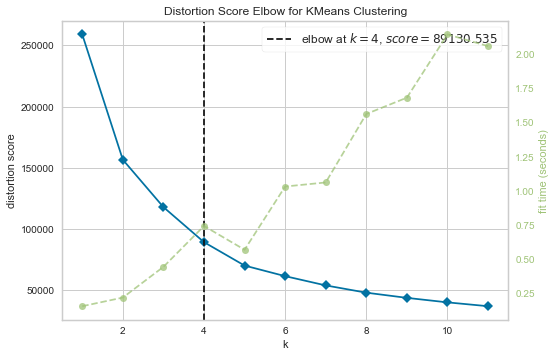

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [38]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 12))

visualizer.fit(data_pca2)    # Fit the data to the visualizer
visualizer.show()    # Finalize and render the figure

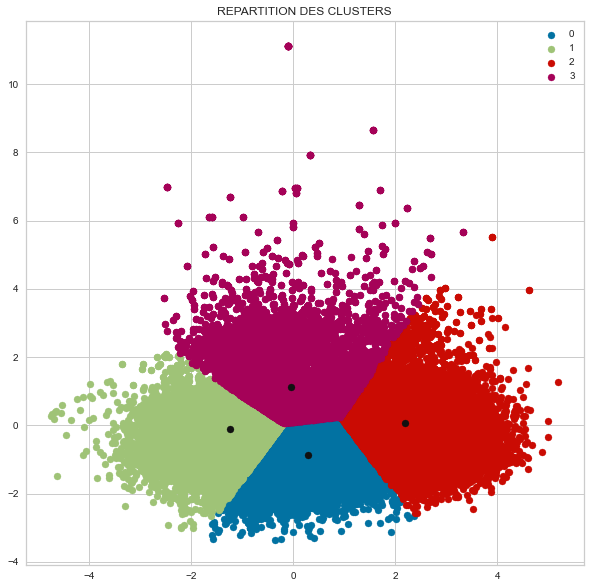

In [39]:
model = KMeans(n_clusters=4)

# Prediction
label = model.fit_predict(data_pca2)
centroids = model.cluster_centers_

# Graphical representation
plt.figure(figsize=(10, 10))
plt.scatter(data_pca2[label == 0, 0], data_pca2[label == 0, 1], label=0)
plt.scatter(data_pca2[label == 1, 0], data_pca2[label == 1, 1], label=1)
plt.scatter(data_pca2[label == 2, 0], data_pca2[label == 2, 1], label=2)
plt.scatter(data_pca2[label == 3, 0], data_pca2[label == 3, 1], label=3)
plt.scatter(centroids[:, 0], centroids[:, 1], color='k')
plt.legend()
plt.title('REPARTITION DES CLUSTERS')
plt.show()

#### Evaluation du modèle

In [40]:
df['model2_cluster'] = label
df_cluster2 = df.groupby('model2_cluster').agg({
    'Recency': 'mean',
    'frequence_achat': 'mean',
    'payment_value': 'mean',
    'delivery_time': 'mean',
    'dist_cust_seller': 'mean'})
df_cluster2

,Recency,frequence_achat,payment_value,delivery_time,dist_cust_seller
model2_cluster,,,,,
0,160.524221,1.000237,187.559377,8.832721,509.711158
1,329.430333,1.005423,215.502332,19.992843,1030.015705
2,237.616868,1.040902,88.567214,4.468673,55.986527
3,408.556681,1.290519,85.458429,11.193049,459.814713


Text(0.5, 1.0, 'Monetary / Cluster')

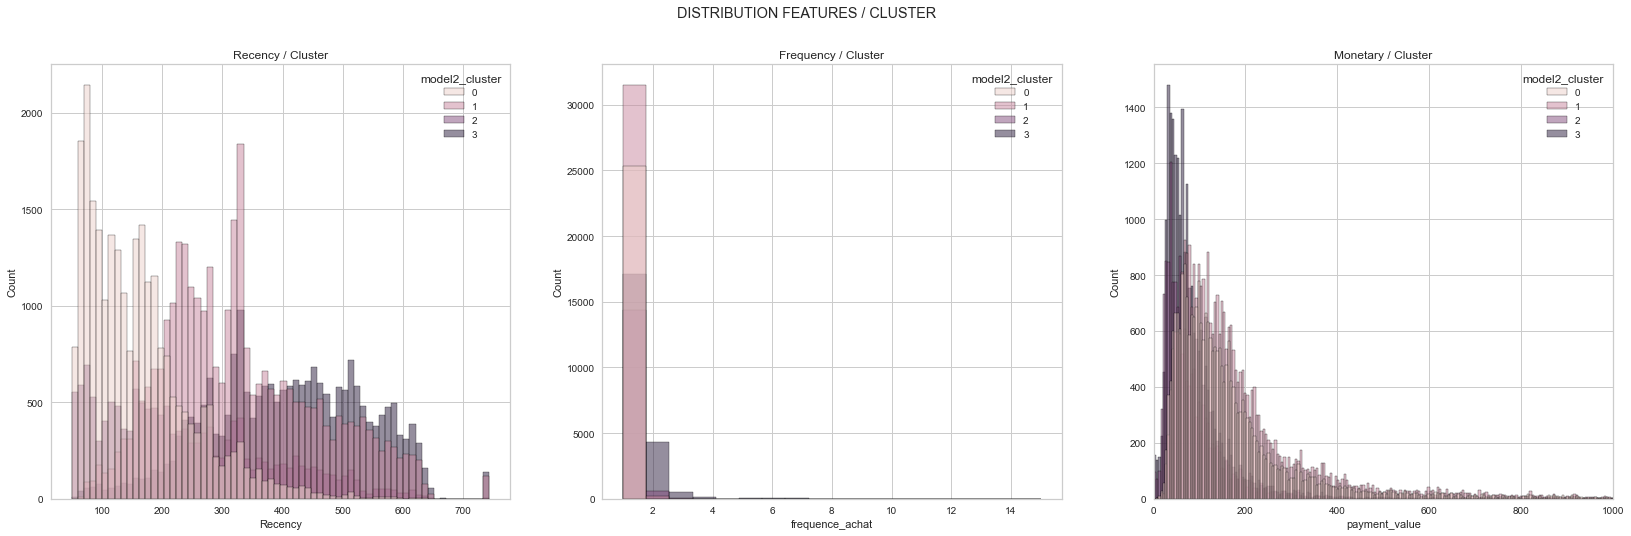

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(28, 8), sharey=False)
fig.suptitle('DISTRIBUTION FEATURES / CLUSTER')

# Recency / Cluster
sns.histplot(ax=axes[0], data=df, x='Recency', hue='model2_cluster')
axes[0].set_title('Recency / Cluster')

# Frequency / Cluster
sns.histplot(ax=axes[1], data=df, x='frequence_achat', hue='model2_cluster')
plt.xlim(0, 10)
axes[1].set_title('Frequency / Cluster')

# Monetary / Cluster
sns.histplot(ax=axes[2], data=df, x='payment_value', hue='model2_cluster')
plt.xlim(0, 1000)
axes[2].set_title('Monetary / Cluster')

Text(0.5, 1.0, 'Delivery / Cluster')

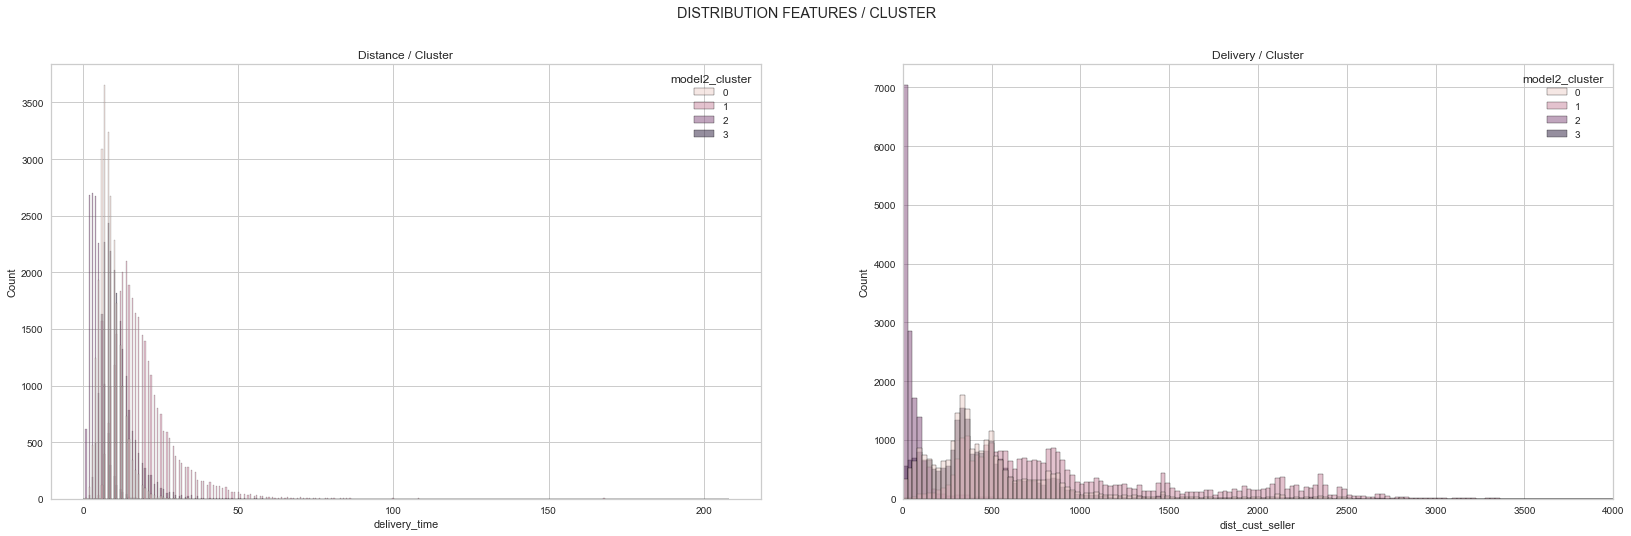

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(28, 8), sharey=False)
fig.suptitle('DISTRIBUTION FEATURES / CLUSTER')

# Distance / Cluster
sns.histplot(ax=axes[0], data=df, x='delivery_time', hue='model2_cluster')
plt.xlim(0, 100)
axes[0].set_title('Distance / Cluster')

# Delivery / Cluster
sns.histplot(ax=axes[1], data=df, x='dist_cust_seller', hue='model2_cluster')
plt.xlim(0, 4000)
axes[1].set_title('Delivery / Cluster')

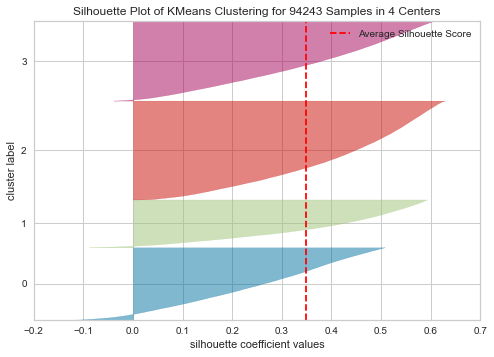

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 94243 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [43]:
model = KMeans(n_clusters=4)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(data_pca2)
visualizer.show()

In [44]:
print('Silhouette Score:', silhouette_score(data_pca2, label))

Silhouette Score: 0.3488280921343763


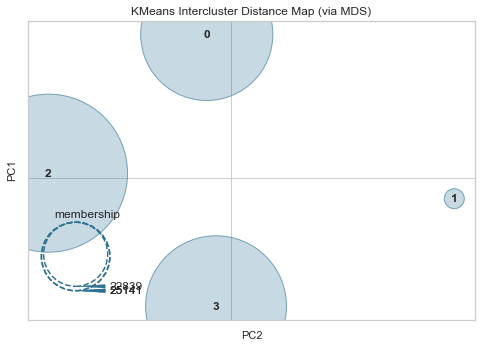

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [45]:
visualizer = InterclusterDistance(model)

visualizer.fit(data_pca2)
visualizer.show()

### Model 3 (8 features avec log + StandardScaler)

In [77]:
customers3 = pd.DataFrame()
customers3['Recency'] = df['Recency_t']
customers3['Frequence'] = df['Frequency_t']
customers3['Monetary'] = df['Monetary_t']
customers3['Delivery'] = df['Delivery_t']
customers3['Distance'] = df['Distance_t']
customers3['Review'] = df['review_score']
customers3['Riche'] = df['m_quartile']
customers3['City'] = df['customer_city']
customers3['Product'] = df['product_category_name_english']
customers3.reset_index(inplace=True)

In [78]:
customers3 = customers3.drop(['index'], axis=1)

In [79]:
columns_cat = ['Product']

In [80]:
km_cao = KModes(n_clusters=4, init='Cao', n_init=1, verbose=1)
fitClusters_cao = km_cao.fit_predict(customers3)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 67, cost: 546132.0


In [81]:
# Predicted Clusters
fitClusters_cao

array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

In [82]:
df["model3_cluster"] = fitClusters_cao
df_cluster3 = df.groupby('model3_cluster').agg({
    'Recency': 'mean',
    'frequence_achat': 'mean',
    'payment_value': 'mean',
    'delivery_time': 'mean',
    'dist_cust_seller': 'mean',
    'review_score': 'mean',
    'm_quartile': 'mean',
    'customer_city': 'mean',
    'product_category_name_english': lambda x: x.value_counts().index[0]})
df_cluster3

,Recency,frequence_achat,payment_value,delivery_time,dist_cust_seller,review_score,m_quartile,customer_city,product_category_name_english
model3_cluster,,,,,,,,,
0,292.373417,1.082370,138.320494,12.822972,623.079042,4.163812,2.663867,1.288395,furniture
1,282.484481,1.074054,120.107030,10.525592,406.738241,4.185861,3.038479,3.832471,healthcare
2,282.632392,1.077412,288.876758,13.138745,699.731599,4.063529,1.591765,1.695686,tech
3,287.996199,1.063204,156.406431,13.633587,742.691712,4.164555,1.969595,0.847480,healthcare


In [119]:
df.to_csv(
    r"C:\Users\Damien\Desktop\Data Scientist\P5\Dataset\olist_stab.csv", index=False)